# Author : Alexandre Gerzewski Da Silva
## Email  : alexandre19923@gmail.com
## GitHub : AlexandreG1998

In [1]:
import pandas as pd
import random
import numpy as np
import ta as ta
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from keras.utils.vis_utils import plot_model
import pydot
from keras.models import model_from_json
import graphviz
from tensorflow import keras
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import pandas_datareader
from pandas_datareader import data

import tensorflow.contrib.keras
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import activations

from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import sklearn.svm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from arch import arch_model
import quandl
from statsmodels.tsa.api import VAR, DynamicVAR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Function to get OBV indicator, the ta version don't work as expected.
def OBV(close,volume):
    obv = volume
    obv = np.where(close > close.shift(), volume + obv.shift(),obv.shift() - volume)
    return(obv)

In [3]:
# Function to get a SVR model
def get_SVR (dataset = None, timestep = 30, yahed = 1, cut_ = 0.3):
    dataset = pd.DataFrame(dataset)
    dataset.columns = ["X"]
    for i in range(1,timestep):
        nome = "X."+str(i)
        dataset[nome] = dataset["X"].shift()
    dataset = dataset.dropna()
    Y = dataset["X"].shift(-yahed)
    cut = int(cut_ * len(dataset))
    train_x = dataset[:cut].values
    train_y = Y[:cut].values
    model = sklearn.svm.SVR()
    model.fit(train_x,train_y)
    return(model)

In [4]:
#Import Dataset of PETR4.SA 5 minuts period
petr = pd.read_csv("petr4m5.csv", sep=';')
petr = petr.set_index("Data")
petr = petr.dropna()
petr.head()

,Open,High,Low,Close,Tickvol,Volume
Data,,,,,,
2014.10.15 14:30,18.93,19.02,18.93,19.01,1309,872600
2014.10.15 14:35,19.02,19.02,18.96,18.99,1025,832800
2014.10.15 14:40,18.99,19.04,18.93,19.00,1043,1147600
2014.10.15 14:45,18.99,19.13,18.97,19.11,1193,733800
2014.10.15 14:50,19.12,19.16,19.08,19.09,1431,696400


In [5]:
# Prepare Dataset:

petr_ = petr

petr_["Daily Return"] = ((petr_["Close"]/petr_["Close"].shift())-1) * 100
petr_["Y Return"] = ((petr_["Close"]/petr_["Close"].shift(-5))-1) * -100
petr_["Range"] = ((petr_["High"]/petr_["Low"])-1 ) * 100
petr_["Body"] = np.where(petr_["Range"] != 0, 
                         abs((petr_["Close"]-petr_["Open"])/(petr_["High"]-petr_["Low"]) * 100),0)
petr_["OBV"] = OBV(petr_["Close"], petr_["Volume"])
petr_["m20"] = petr_["Close"].rolling(20).mean()
petr_["m200"] = petr_["Close"].rolling(200).mean()
petr_["std20"] = petr_["Close"].rolling(20).std()

petr_["SB20"] = petr_["m20"] + (petr_["std20"] * 2)
petr_["IB20"] = petr_["m20"] - (petr_["std20"] * 2)
petr_["Bp"] = ((petr_["SB20"] - petr_["IB20"])/ petr_["m20"]) * 100
petr_["RSL"] = ((petr_["Close"]/petr_["m20"])-1) * 100
petr_['RSL 200'] = ((petr_["Close"]/petr_["m200"])-1) * 100

petr_["m20 - m200"] =  ((petr_["m20"]/petr_["m200"])-1) * 100
petr_["Return m20"] = ((petr_["m20"]/petr_["m20"].shift())-1) * 100
petr_["Return m200"] = ((petr_["m200"]/petr_["m200"].shift())-1) * 100
petr_["Return STD"] = petr_["Daily Return"].rolling(106).std()

petr_["Squeeze"] = np.where(petr_["Close"] > petr_["SB20"],1,np.where(petr_["Close"] < petr_["IB20"],-1,0))

petr_["Trend"] = np.where((petr_["Daily Return"] > 0) & (petr_["RSL"] > 0) & 
                          (petr_["m20 - m200"] > 0) & (petr_["Return m20"] > 0) & (petr_["Return m200"] > 0),1,
                         np.where((petr_["Daily Return"] < 0) & (petr_["RSL"] < 0) & 
                          (petr_["m20 - m200"] < 0) & (petr_["Return m20"] < 0) & (petr_["Return m200"] < 0),-1,0))


petr_ = petr_.dropna()
petr_ = petr_.drop("m20", axis=1)
petr_ = petr_.drop("m200", axis=1)
petr_ = petr_.drop("SB20", axis=1)
petr_ = petr_.drop("IB20", axis=1)
petr_ = petr_.drop("std20", axis=1)

petr_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,Return m200,Return STD,Squeeze,Trend
Data,,,,,,,,,,,,,,,,,,,,
2014.10.20 10:40,18.07,18.10,18.04,18.07,215,302100,0.000000,-2.148106,0.332594,0.000000,91700.0,2.757294,-0.522984,-2.298975,-1.785328,-0.085256,-0.025406,0.513641,0,0
2014.10.20 10:45,18.07,18.09,17.90,17.98,1189,1162300,-0.498063,-0.954520,1.061453,47.368421,-860200.0,2.764003,-0.922992,-2.759037,-1.853149,-0.096339,-0.027304,0.515830,0,-1
2014.10.20 10:50,17.98,18.04,17.98,17.99,349,572300,0.055617,-1.695873,0.333704,16.666667,1734600.0,2.766290,-0.785882,-2.678373,-1.907482,-0.082656,-0.027312,0.515734,0,0
2014.10.20 10:55,18.00,18.01,17.91,17.91,637,690000,-0.444691,-1.129305,0.558347,90.000000,-117700.0,2.832704,-1.120742,-3.079695,-1.981157,-0.107542,-0.032459,0.514825,0,-1
2014.10.20 11:00,17.93,17.93,17.81,17.85,925,1159700,-0.335008,-0.393701,0.673779,66.666667,-469700.0,2.789191,-1.310333,-3.371967,-2.089006,-0.143543,-0.033551,0.515466,0,-1


In [6]:
# Get SVR :
svm_STD_returns1 = get_SVR(petr_.iloc[:,17:18].values)
svm_STD_returns2 = get_SVR(petr_.iloc[:,17:18].values, yahed=2)
svm_STD_returns3 = get_SVR(petr_.iloc[:,17:18].values, yahed=3)
svm_STD_returns4 = get_SVR(petr_.iloc[:,17:18].values, yahed=4)
svm_STD_returns5 = get_SVR(petr_.iloc[:,17:18].values, yahed=5)

In [7]:
# Get sequence data and forecast next STD of returns:

for i in range(1,30):
    nome = None
    nome = "RetornoL."+str(i)
    petr_[nome] = petr_["Daily Return"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RangeL."+str(i)
    petr_[nome] = petr_["Range"].shift(i)
for i in range(1,30):
    nome = None
    nome = "BodyL."+str(i)
    petr_[nome] = petr_["Body"].shift(i)
for i in range(1,30):
    nome = None
    nome = "OBVL."+str(i)
    petr_[nome] = petr_["OBV"].shift(i)
    
    nome = "BpL."+str(i)
for i in range(1,30):
    nome = None
    petr_[nome] = petr_["Bp"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "RSL20L."+str(i)
    petr_[nome] = petr_["RSL"].shift(i)
for i in range(1,30):
    nome = None
    nome = "RSL200L."+str(i)
    petr_[nome] = petr_["RSL 200"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "TrendL."+str(i)
    petr_[nome] = petr_["Trend"].shift(i)
    
for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    petr_[nome] = petr_["Return STD"].shift(i)

    
petr_ = petr_.dropna()

print(petr_.columns)


preverSTD =petr_.iloc[:,17:18]


for i in range(1,30):
    nome = None
    nome = "Return STDL."+str(i)
    preverSTD[nome] = petr_[nome]


petr_["STD y1"] = svm_STD_returns1.predict(preverSTD.values)
petr_["STD y2"] = svm_STD_returns2.predict(preverSTD.values)
petr_["STD y3"] = svm_STD_returns3.predict(preverSTD.values)
petr_["STD y4"] = svm_STD_returns4.predict(preverSTD.values)
petr_["STD y5"] = svm_STD_returns5.predict(preverSTD.values)


Index([          'Open',           'High',            'Low',          'Close',
              'Tickvol',         'Volume',   'Daily Return',       'Y Return',
                'Range',           'Body',
       ...
       'Return STDL.20', 'Return STDL.21', 'Return STDL.22', 'Return STDL.23',
       'Return STDL.24', 'Return STDL.25', 'Return STDL.26', 'Return STDL.27',
       'Return STDL.28', 'Return STDL.29'],
      dtype='object', length=253)


In [8]:
petr_.head()

,Open,High,Low,Close,Tickvol,Volume,Daily Return,Y Return,Range,Body,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2014.10.20 13:05,17.72,17.79,17.68,17.78,979,498200,0.282008,0.447928,0.622172,54.545455,...,0.515466,0.514825,0.515734,0.515830,0.513641,0.431002,0.424643,0.421312,0.420104,0.418266
2014.10.20 13:10,17.78,17.84,17.75,17.82,820,259100,0.224972,0.056085,0.507042,44.444444,...,0.521632,0.515466,0.514825,0.515734,0.515830,0.430470,0.424294,0.421094,0.419953,0.418189
2014.10.20 13:15,17.82,17.87,17.75,17.82,969,556700,0.000000,-0.000000,0.676056,0.000000,...,0.525689,0.521632,0.515466,0.514825,0.515734,0.429546,0.423545,0.420471,0.419391,0.417692
2014.10.20 13:20,17.83,17.87,17.80,17.81,787,193800,-0.056117,0.279955,0.393258,28.571429,...,0.529208,0.525689,0.521632,0.515466,0.514825,0.428173,0.422336,0.419380,0.418353,0.416708
2014.10.20 13:25,17.81,17.88,17.81,17.82,795,279200,0.056148,0.056085,0.393038,14.285714,...,0.525127,0.529208,0.525689,0.521632,0.515466,0.426944,0.421277,0.418443,0.417471,0.415884


In [10]:
# Delete the no squeeze rows
backup = petr_
df = petr_.drop(petr_[petr_["Squeeze"] == 0].index,  inplace=True)
petr_.iloc[:,6:].head()
df = petr_.iloc[:,6:]


In [11]:
df.head()

,Daily Return,Y Return,Range,Body,OBV,Bp,RSL,RSL 200,m20 - m200,Return m20,...,Return STDL.25,Return STDL.26,Return STDL.27,Return STDL.28,Return STDL.29,STD y1,STD y2,STD y3,STD y4,STD y5
Data,,,,,,,,,,,,,,,,,,,,,
2014.10.20 14:55,-0.560224,-0.112803,0.619718,90.909091,-14300.0,0.767215,-0.524000,-2.702673,-2.190149,-0.019611,...,0.381961,0.381706,0.383410,0.390339,0.392231,0.410724,0.407648,0.406635,0.406512,0.405924
2014.10.20 15:00,0.056338,0.056275,0.395034,14.285714,1347300.0,0.860375,-0.454010,-2.637984,-2.193935,-0.014011,...,0.381723,0.381961,0.381706,0.383410,0.390339,0.410562,0.407495,0.406490,0.406368,0.405782
2014.10.20 15:15,-0.281215,-0.282805,0.564653,40.000000,-117000.0,1.064456,-0.566429,-2.769133,-2.215251,-0.028033,...,0.383373,0.382866,0.381562,0.381723,0.381961,0.411039,0.407994,0.407003,0.406894,0.406325
2014.10.20 15:35,-0.620068,0.564016,0.681044,91.666667,-851700.0,1.503417,-0.977308,-3.257315,-2.302509,-0.075768,...,0.382785,0.381944,0.382472,0.383284,0.383373,0.412634,0.409619,0.408648,0.408565,0.408032
2014.10.20 16:20,-1.014085,-1.209677,1.537585,66.666667,-1287400.0,1.558232,-0.924777,-3.458621,-2.557495,-0.070436,...,0.383303,0.384928,0.384118,0.384575,0.384757,0.421711,0.418851,0.417985,0.418041,0.417708


In [12]:
# Prepare dataset for input in ANN

Y = df.iloc[:,1:2]
df = df.drop("Y Return", axis=1)

Yc = np.where(Y["Y Return"] > 0 ,1,0)

# Use MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))



cut = int(df.shape[0] * 0.7)

x_train = df[:cut].values
y_train = Yc[:cut]

x_test = df[cut:].values
y_test = df[cut:]


x_train_scaled = sc.fit_transform(x_train)
x_test_scaled = sc.transform(x_test)

#Use full dataset for final test
df_scaled = sc.transform(df.values)

In [13]:
model = Sequential()
model.add(Dense(units=251, input_dim = x_train_scaled.shape[1], activation="relu"))
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = "sigmoid"))

model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["acc"])

history = model.fit(x_train_scaled, y_train, batch_size=1000, epochs=100)

Epoch 1/100
7942/7942 [==============================] - 3s 422us/step - loss: 0.6991 - acc: 0.5086
Epoch 2/100
7942/7942 [==============================] - 2s 191us/step - loss: 0.6939 - acc: 0.5174
Epoch 3/100
7942/7942 [==============================] - 1s 172us/step - loss: 0.6925 - acc: 0.5274
Epoch 4/100
7942/7942 [==============================] - 2s 295us/step - loss: 0.6901 - acc: 0.5345
Epoch 5/100
7942/7942 [==============================] - 2s 238us/step - loss: 0.6912 - acc: 0.5293
Epoch 6/100
7942/7942 [==============================] - 2s 259us/step - loss: 0.6892 - acc: 0.5402
Epoch 7/100
7942/7942 [==============================] - 3s 370us/step - loss: 0.6900 - acc: 0.5325
Epoch 8/100
7942/7942 [==============================] - 3s 351us/step - loss: 0.6902 - acc: 0.5385
Epoch 9/100
7942/7942 [==============================] - 3s 345us/step - loss: 0.6888 - acc: 0.5408
Epoch 10/100
7942/7942 [==============================] - 2s 289us/step - loss: 0.6889 - acc: 0.5329

7942/7942 [==============================] - 2s 252us/step - loss: 0.6060 - acc: 0.6580
Epoch 83/100
7942/7942 [==============================] - 2s 245us/step - loss: 0.5997 - acc: 0.6626
Epoch 84/100
7942/7942 [==============================] - 2s 301us/step - loss: 0.5867 - acc: 0.6792
Epoch 85/100
7942/7942 [==============================] - 2s 234us/step - loss: 0.5914 - acc: 0.6740
Epoch 86/100
7942/7942 [==============================] - 2s 219us/step - loss: 0.5798 - acc: 0.6842
Epoch 87/100
7942/7942 [==============================] - 2s 257us/step - loss: 0.5749 - acc: 0.6905
Epoch 88/100
7942/7942 [==============================] - 2s 252us/step - loss: 0.5681 - acc: 0.6994
Epoch 89/100
7942/7942 [==============================] - 2s 236us/step - loss: 0.5695 - acc: 0.6981
Epoch 90/100
7942/7942 [==============================] - 2s 203us/step - loss: 0.5573 - acc: 0.7096
Epoch 91/100
7942/7942 [==============================] - 2s 206us/step - loss: 0.5540 - acc: 0.7055
Epo

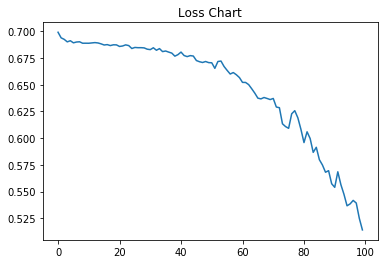

In [14]:
plt.plot(history.history["loss"])
plt.title("Loss Chart")
plt.show()

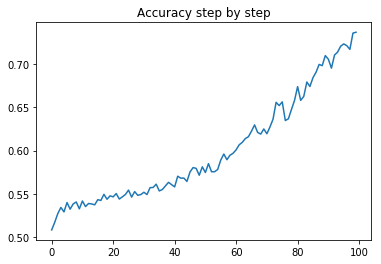

In [15]:
plt.plot(history.history["acc"])
plt.title("Accuracy step by step")
plt.show()

In [20]:
Y["Previsto"] = model.predict(df_scaled)
#Get the class by quartile 
Y["Classe"] = np.where(Y["Previsto"] <= np.percentile(Y["Previsto"].values,q=25 ),1,
 np.where((Y["Previsto"] > np.percentile(Y["Previsto"].values,q=25 )) & 
          (Y["Previsto"] <= np.percentile(Y["Previsto"].values,q=50 )),2,
          np.where((Y["Previsto"] > np.percentile(Y["Previsto"].values,q=50 )) & 
          (Y["Previsto"] <= np.percentile(Y["Previsto"].values,q = 75 )),3,
          np.where(Y["Previsto"] > np.percentile(Y["Previsto"].values,q = 75 ),4,0))))

#Use to backtest the last 30% of dataset
Y[:cut].groupby("Classe")["Y Return"].sum()


Classe
1   -1101.311009
2    -284.259762
3     256.489444
4     990.629313
Name: Y Return, dtype: float64

In [27]:
Y["Squeeze"] = df["Squeeze"].values
Y["Sinal"] = np.where(Y["Classe"] == 1, 1,np.where(Y["Classe"] == 4,-1,0))

Y["Pontos"] = Y["Y Return"] * Y["Sinal"]

Y["Acumulado"] = Y["Pontos"].cumsum()

Y_ = Y[cut:]
Y_["Acumulado"] = Y_["Pontos"].cumsum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
Y_.head()

,Y Return,Previsto,Classe,Sinal,Pontos,Squeeze,Acumulado
Data,,,,,,,
2018.02.19 10:35,-0.210416,0.582934,2,0,-0.000000,1,-0.000000
2018.02.19 15:05,-0.052138,0.732985,3,0,-0.000000,1,-0.000000
2018.02.19 15:35,0.104004,0.131994,1,1,0.104004,1,0.104004
2018.02.19 16:00,0.311042,0.830582,4,-1,-0.311042,1,-0.207038
2018.02.19 16:05,-0.051894,0.293330,1,1,-0.051894,1,-0.258932


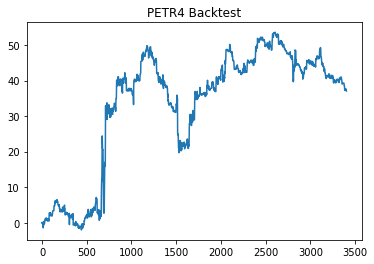

In [29]:
plt.plot(Y_["Acumulado"].values)
plt.title("PETR4 Backtest")
plt.show()